In [1]:
%matplotlib inline


Training LeNet with Constrained Convolution Kernals
===============
In this part, we consider to train LeNet with constrained convolution kernals. 

![mnist.png](../pics/mnist.png)




It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output. Such network can be constructed using the layers from ``torch.nn`` and `cdopt.utils_torch.nn`. 

A typical training procedure for a neural network with constraints is as follows:

- Define the neural network that has some learnable parameters (or
  weights), combined with layers from `cdopt.utils_torch.nn` and `torch.nn`. 
- Define the loss function that evaluates how far is the output from being correct.
- Design the traning and test processes.
- Load dataset and set configs to the training process.
- Train the neural network by optimizers from `torch.optim`



This project may require the `matplotlib` and `tqdm` packages. You can install them through `pip`. 

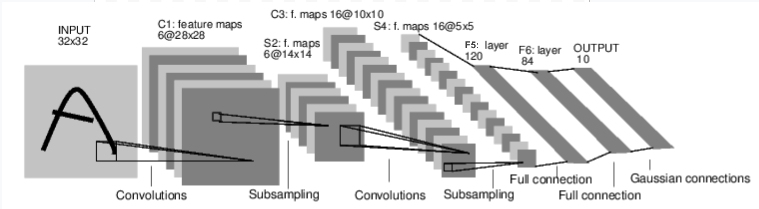

## Importing modules
We first import all the necessary modules for training LeNet. 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cdopt
from cdopt.nn.modules import Linear_cdopt, Conv2d_cdopt
from cdopt.manifold_torch import stiefel_torch




## Define the structure of the network

In [3]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel, the `manifold_class` can be chosen as any manifold class provided in `cdopt.manifold_torch`
        self.conv1 = Conv2d_cdopt(1, 6, 5, manifold_class=stiefel_torch)
        self.conv2 = Conv2d_cdopt(6, 16, 5, manifold_class=stiefel_torch)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256, 120)  # 5*5 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d_cdopt(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d_cdopt(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Training the Network
-------------

Then we define the training and testing process of the network. 



In [4]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) + 0.05* (model.conv1.quad_penalty() + model.conv2.quad_penalty())

        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            




In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Set parameters and options
------------------

In [6]:
class ARGS():
    pass
args = ARGS()
args.batch_size = 64    
args.test_batch_size = 1000 
args.epochs = 5
args.lr = 0.5    # learning rate
args.gamma = 0.7 # weight-decay parameter
args.no_cuda = False  # whether use cuda 
args.seed = 1  # random seed for traning
args.log_interval = 200   # the interval to print trainning information
args.save_model = False   # whether to save the model

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

In [8]:
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

if args.save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323425
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.337492
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.173824
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.047076
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.142316

Test set: Average loss: 0.0612, Accuracy: 9793/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.077553
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.018011
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.019138
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.028631
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.152057

Test set: Average loss: 0.0469, Accuracy: 9830/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.012290
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.030673
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.008544
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.012734
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.011106

Test set: Average loss: 0.0363, Accuracy: 9889/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.004471
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [9]:
[model.conv1.quad_penalty(), model.conv2.quad_penalty()]

[tensor(7.8502e-05, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0.0003, device='cuda:0', grad_fn=<SumBackward0>)]

Reference
----------
1. https://github.com/pytorch/examples/tree/main/mnist
2. Hu X, Xiao N, Liu X, et al. A Constraint Dissolving Approach for Nonsmooth Optimization over the Stiefel Manifold[J]. arXiv preprint arXiv:2205.10500, 2022.